In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from collections import Counter
import re

# Add parent directory to path so we can import from useful_tools
import sys
import os
sys.path.append(os.path.split(os.path.abspath(os.getcwd()))[0])
from useful_tools import ModelTester, plot_confusion_matrix

# Spam-filter

I denne oppgaven skal vi lage et enkelt spamfilter for SMS. Ideen er at det er noen ord som er mer vanlige i spam-meldinger, enn i vanlige meldinger.

## Ord som trigger spam-filteret
Man kan dele spam-meldinger inn i forskjellige kategorier. Kategorien vil vi prøve å anslå ved å se på ordene som er i meldingen. Nedenfor har vi noen kategorier representert ved hver sin liste i en dictionary. Vi lar de være tomme til å begynne med.

In [2]:
spam_lists = {
    'free': [],
    'winner': [],
    'congrats': [],
    'adult': [],
    'attention': [],
    'ringtone': []
}

## Prosessering av dataene
Fordi vi selv bestemmer variablene i datene i denne oppgaven, er vi nødt til å gå gjennom alle meldingene og finne ut om de hører hjemme i noen av kategoriene vi har definert. 

For eksempel kan det hende at vi har lagt til ordet "award" i `winner_list`. Dersom en en melding inneholder ordet "award", vil vi sette `winner`-variablen for den meldingen til 1.

Funksjonen nedenfor tar en dictionary på formen slik som `spam_lists` i forrige celle, og prosesserer dataene slik som beskrevet ovenfor. I tillegg lager den test- og treningssett, samt en ModelTester for treningsdataene. Du behøver ikke lese koden. Nederst i cellen kaller vi på funksjonen, og får datasettene ut.

In [3]:
def get_datasets(spam_lists):
    with open('../../datasets/sms_spam/SMSSpamCollection.txt') as infile:
        data = pd.read_csv(infile, delimiter='\t', header=-1)

    data.columns = ['spam', 'message']
    data['spam'] = (data['spam'] == 'spam').astype(int)
    
    # Standardverdi er 0 for alle variablene
    for name in spam_lists.keys():
        data[name] = 0
        
    # Gå gjennom hver melding og sett passende variabel til 1 hvis man finner et trigger-ord
    for index, data_item in data.iterrows():
        message = data_item['message'].lower()
        
        for variable_name, word_list in spam_lists.items():
            if any(word in message for word in word_list):
                data.loc[index, variable_name] = 1
                
    np.random.seed(190)
    train, test = train_test_split(data, test_size=0.2)
    x_train = train.drop(['spam', 'message'], axis=1)
    y_train = train[['spam']]
    x_test = test.drop(['spam', 'message'], axis=1)
    y_test = test[['spam']]
    
    tester = ModelTester(x_test, y_test)
    
    return x_train, x_test, y_train, y_test, tester, train

# Kaller på funksjonen
x_train, x_test, y_train, y_test, tester, train = get_datasets(spam_lists)

## Klassifisering med besluttningstrær
Vi bruker besluttningstrær til å prøve å klassifiserre meldingene

Confusion matrix, without normalization


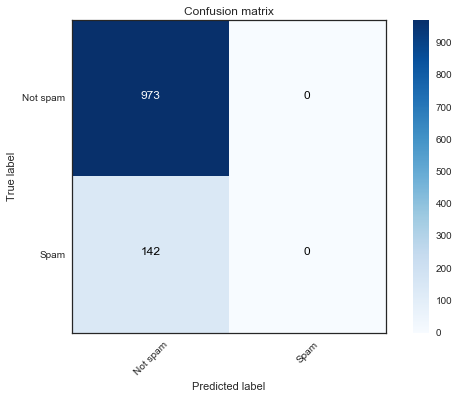

Accuracy:  87.264573991 %


In [4]:
tree_model = DecisionTreeClassifier()
tree_model.fit(x_train, y_train)

cnf_mat, accuracy = tester.test_classifier(tree_model, ['Not spam', 'Spam'])

## Oppgave 1
Hvorfor får vi så høy accuracy, selv om ingen av meldingene ble klassifisert som spam? (Hint: Se på hvor stor andel av meldingene som faktisk er spam)


## Oppgave 2
Forklar hvorfor besluttningstreet velger å klassifisere alle meldingene til ikke-spam, i stedet for å klassifisere alt til spam.

Løsning: Tanken her er at det gir mindre treningsfeil å klassifisere alt til ikke-spam enn alt til spam

## Forbedring av filteret
Nå har vi lyst til å forbedre filteret vårt ved å legge til nye ord i listene fra tidligere.

### Hjelpefunksjoner
Nedenfor er det noen hjelpefunksjoner for å gjøre søket etter viktige ord enklere. Du behøver hverken lese denne seksjonen nøye eller forstå koden. De kan være allikevel være nyttige å bruke.

#### filter_data
Tar en DataFrame og to lister av kollonenavn, som begge er valgfrie.
Funksjonen finner de radene i `df` der alle variablene i `include`-listen er 1,
og alle i `exclude`-listen er 0. Deretter returneres en ny DataFrame med disse radene

Eksempel: `filter_data(train, ['spam', 'free'], ['winner'])` returnerer de radene
i `train` som er `spam` og `free`, men ikke `winner`

In [5]:
def filter_data(df, include=[], exclude=[]):
   
    query_strings = []
    for name in include:
        query_strings.append('{name} == 1'.format(name=name))
    for name in exclude:
        query_strings.append('{name} == 0'.format(name=name))
        
    query_string = ' and '.join(query_strings)
    if query_string == '':
        return df
    
    return df.query(query_string)

#### filter_training
Gjør det samme som `filter_data`, men *alltid* på treningsdataene

In [6]:
def filter_training(include=[], exclude=[]):
    return filter_data(train, include, exclude)

#### count_words
Tar en DataFrame (**OBS**: Må inneholde en `message`-kolonne), og teller forkomsten av hvert ord i meldingene. Returnerer en dictionary på formen `{word: count}` slik at

```python
d = count_words(train)
print(d['hello'])
```
forteller oss hvor mange ganger ordet 'hello' forekommer i treningsdatasettet. **OBS**: Hvis du spør etter et ord som ikke er finnes i den, vil du få en feilmelding.

In [7]:
def count_words(df):
    all_messages = ' '.join(df['message'].values).lower()
    words = re.findall(r'\w+', all_messages)
    counter = Counter(words)
    return counter

#### compare_spam_words
Denne tar en DataFrame (Må ha `spam`- og `message`-kolonner), og teller forekomst av alle ord for spam-meldinger og vanlige meldinger hver for seg. I tillegg regner den ut hvilken andel av hvert ord som forekommer i spam-meldingene.

Returnerer en ny DataFrame med kolonnene:

- `word`: Hvilket ord vi ser på
- `spam_share`: Hvilken andel av forekomstene som er i spam-meldinger. Altså 1 hvis den kun er i spam-meldingene, og 0 hvis den kun er i vanlige meldinger.
- `spam_count`: Hvor mange spam-meldinger vi så ordet i
- `not_spam_count`: Hvor mange vanlige meldinger vi så ordet i

In [8]:
def compare_spam_words(df):
    df_spam = filter_data(df, ['spam'])
    df_no_spam = filter_data(df, exclude=['spam'])
    counter_spam = count_words(df_spam)
    counter_no_spam  = count_words(df_no_spam)
    
    result = []
    for key in set(counter_spam) | set(counter_no_spam):
        spam_count = counter_spam.get(key, 0)
        no_spam_count = counter_no_spam.get(key, 0)
    
        result.append({'word': key, 'spam_share': spam_count/(spam_count + no_spam_count),'spam_count': spam_count, 'not_spam_count': no_spam_count})

    result = pd.DataFrame(result, columns=['word', 'spam_share', 'spam_count', 'not_spam_count']).sort_values(['spam_share', 'spam_count'], ascending=[False, False])
    return result 

### Oppgave 3: Forbedring av filteret

For å kunne klassifisere en melding til spam basert på ordene i listen, må vi sørge for at disse ordene faktisk er vanlige i spam-meldinger. Nedenfor har du en tabell over vanlige ord i spam-meldinger sammenlignet med vanlige meldinger.

Velg ut noen ord du tror er viktige, og putt de i ordlistene nedenfor, i den kategorien du synes passer best. Du kan også legge til nye kategorier, hvis du synes det passer.

Får du noen forbedring i accuracy?

Hvilke kriterier bruker du i valg av nye ord? 

Holder det å bruke bare en av de tre siste kolonnene i tabellen (`smap_share`, `spam_count` eller `not_spam_count`)?
Hvorfor/Hvorfor ikke?

In [9]:
sorted_df = compare_spam_words(train)
print(sorted_df.to_string())

                                    word  spam_share  spam_count  not_spam_count
1424                               claim    1.000000         100               0
5198                               prize    1.000000          83               0
227                                 150p    1.000000          59               0
2330                          guaranteed    1.000000          48               0
4323                                tone    1.000000          46               0
4660                                  18    1.000000          42               0
3833                                 500    1.000000          39               0
4774                                1000    1.000000          38               0
727                              awarded    1.000000          37               0
1597                                  cs    1.000000          35               0
5061                              150ppm    1.000000          30               0
5097                        

Confusion matrix, without normalization


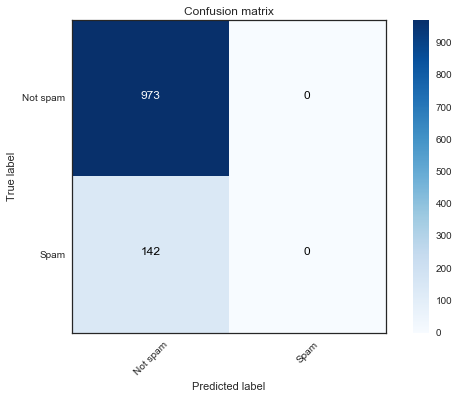

Accuracy:  87.264573991 %


(array([[973,   0],
        [142,   0]]), 0.87264573991031391)

In [10]:
# spam_lists_exercise = {
#     'free':  ['free'],
#     'winner':   ['winner', 'win', 'won', 'award', 'selected'],
#     'congrats':  ['congrats', 'congratulations'],
#     'adult':  ['xxx', 'babe', 'naked', 'dirty', 'flirty'],
#     'attention':  ['urgent', 'attention', 'bonus', 'immediately'],
#     'ringtone':  ['ringtone']
# }

# spam_lists['free'].append([])
# spam_lists['winner'].append(['prize', 'www', 'awarded', 'cash'])
# spam_lists['congrats'].append(['draw', 'free', 'claim', 'gift', 'guaranteed'])
# spam_lists['adult'].append([])
# spam_lists['attention'].append([])
# spam_lists['ringtone'].append(['unsubscribe', 'subscription', 'subscribe'])

spam_lists_exercise = {
    'free': [],
    'winner': [],
    'congrats': [],
    'adult': [],
    'attention': [],
    'ringtone': []
}

x_train_exercise, x_test_exercise, y_train_exercise, y_test_exercise, tester_exercise, train_exercise = get_datasets(spam_lists_exercise)

train_exercise.head()
tree_model_exercise = DecisionTreeClassifier()
tree_model_exercise.fit(x_train_exercise, y_train_exercise)
predictions = tree_model_exercise.predict(x_test_exercise)
#confusion_matrix(y_test['spam'], predictions)
tester_exercise.test_classifier(tree_model_exercise, ['Not spam', 'Spam'])

### Oppgave 4: Feilklassifisering
Nå som du forhåpentligvis har fått spam-filteret til å klassifisere noen av spam-meldingene riktig, har du antakelig også klassifisert noen vanlige meldinger til spam (se på forvirringsmatrisen).

Se for deg at du har et spam-filter som klarer å fange opp _alle_ spam-meldinger, men som ganske ofte også stanser en vanlig SMS. Vil dette filteret være å foretrekket fremfor et som ofte slipper gjennom spam, men som sjeldent eller aldri stanset vanlige meldinger? Hvorfor/Hvorfor ikke?

Vi skal nå prøve å redusere antallet av vanlige meldinger som blir klassifisert til spam i modellen fra forrige oppgave.

Modellen fra forrige oppgave har en metode `predict_proba`, som forteller oss noe om sannsynligheten for at en meldigen hører til i spam-klassen eller ikke. 

Vi kan bruke dette til å kun klassifisere til spam hvis vi er *veldig* sikre. Vi setter f.eks. en grense `threshold = 0.9` og klassifiserer så kun meldinger til spam hvis vi er mer enn 90 % sikre.

Prøv forskjellige verdier for `threshold` nedenfor, og se om du kan redusere antallet vanlige meldinger som blir klassifisert til spam.

Hva skjer ellers med kvaliteten på filteret?

Ville du foretrukket dette filteret, eller det du har fra forrige oppgave?

Confusion matrix, without normalization


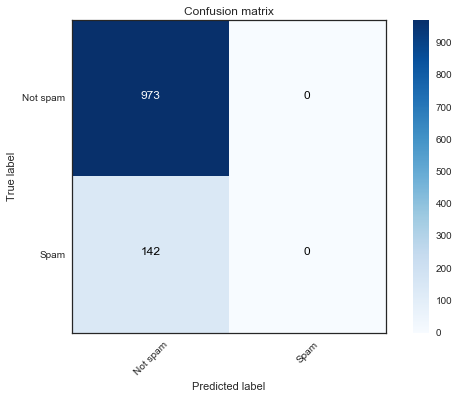

Accuracy: 87.264573991 %


In [11]:
# Mellom 0 og 1 (1 er 100 % sikker)
threshold = 0.9

# Regner ut sannsynlighetene
probabilities = tree_model_exercise.predict_proba(x_test_exercise)
# Klassifiserer de men sannsynlighet for å være spam større enn threshold til å være spam
predictions = np.greater(probabilities[:,1], threshold).astype(int)

# Plotting av forvirringsmatrise og accuracy (Samme som ModelTester.test_classifier)
plot_confusion_matrix(confusion_matrix(y_test_exercise, predictions), ['Not spam', 'Spam'])
plt.show()
print('Accuracy:', sum(predictions == y_test['spam'])/len(y_test)*100, '%')




## Bonusoppgave 1: Klassifisering av nye meldinger

Skriv en eller flere meldinger og kjør de gjennom spam-filterne du har laget så langt. Blir resultatet slik du trodde?

Her må du programmere en del selv, men du kan selvsagt bruke kode fra oppgaven til hjelp/inspirasjon. Først må du finne ut hvilke kategorier meldingen hører til (Hint: Du kan se på `get_datasets`), og så bruke modellens `predict`-metode for å klassifisere den til spam eller ikke-spam.